In [ ]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print(accelerator)

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
!(test -d training || (wget http://swarm.cs.pub.ro/~ccruceru/cil/training.zip && unzip training.zip)) && \
  (test -d testing || (wget http://swarm.cs.pub.ro/~ccruceru/cil/testing.zip && unzip.testing.zip))
!(test -f unet_models.py || wget http://swarm.cs.pub.ro/~ccruceru/cil/unet_models.py)
!ls training/ testing/

In [1]:
import cv2
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

from torch import nn
from unet_models import unet11
from torch.nn import functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.transforms import ToTensor, Normalize, Compose
%matplotlib inline

/home/ccruceru/.local/lib/python3.5/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def cuda(x):
    return x.cuda(async=True) if torch.cuda.is_available() else x


def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

In [3]:
def get_model():
    model = unet11(pretrained=True)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model

In [4]:
model = get_model()

In [5]:
def load_image(path, pad=True):
    """
    Load image from a given path and pad it on the sides, so that eash side is 
    divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as
        (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if not pad:
        return img
    
    height, width, _ = img.shape
    
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

In [27]:
img, pads = load_image('../data/training/images/001.png', pad=True)

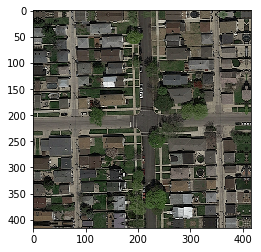

In [28]:
plt.imshow(img)

In [8]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_img = torch.unsqueeze(variable(img_transform(img), volatile=False), dim=0)

In [9]:
out = model(input_img)

In [10]:
def crop_image(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2] 
    
    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]

In [11]:
print(out.size())
mask = F.sigmoid(out)
mask_array = mask.data[0].cpu().numpy()[0]
mask_array = crop_image(mask_array, pads)

torch.Size([1, 1, 416, 416])


/local/calin/miniconda3/envs/cil/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


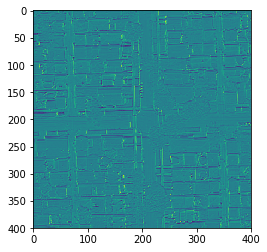

In [12]:
plt.imshow(mask_array)
plt.grid('off')

In [13]:
# create some fake mask as a target
target = torch.zeros_like(mask)

criterion = nn.BCELoss()

loss = criterion(mask, target)
print('loss: ',loss)

# calculate gradients
loss.backward()

loss:  tensor(0.6243, device='cuda:0')


In [14]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# retrieve the raw images
def load_data():
    n_training = len(glob.glob('../data/training/images/*.png'))
    X = torch.zeros(n_training, 3, 416, 416)
    
    for i, image in enumerate(glob.glob('../data/training/images/*.png')):
        x, _ = load_image(image, pad=True)
        X[i] = img_transform(x)
        
    Y = torch.zeros(n_training, 1, 416, 416)
    for i, image in enumerate(glob.glob('../data/training/groundtruth/*.png')):
        y, _ = load_image(image, pad=True)
        y = np.max(y, axis=2).astype(np.float)
        y[y > 0] = 1.0
        y = torch.from_numpy(np.expand_dims(y, axis=0))
        Y[i] = y
  
    return X, Y

In [16]:
X, y = load_data()
print(X.shape, y.shape)

torch.Size([200, 3, 416, 416]) torch.Size([200, 1, 416, 416])


In [21]:
def train(X, y, model, num_epochs, mini_batch_size):
    adam = Adam(model.parameters(), lr=0.0001)
    n_samples = X.size()[0]
    criterion = nn.BCELoss()

    for epoch in range(num_epochs):
        adam.zero_grad()
        mini_batch = np.random.choice(n_samples, size=mini_batch_size)
        
        X_batch = X[mini_batch]
        y_batch = variable(y[mini_batch])
            
        y_pred = model(variable(X_batch))
        y_pred = F.sigmoid(y_pred)
        
        loss = criterion(y_pred, y_batch)
        print('loss: ', loss)
        loss.backward()
        adam.step()

In [ ]:
train(X, y, model, 100, 16)
torch.save(model.state_dict(), 'TernausNet.pt')

/local/calin/miniconda3/envs/cil/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


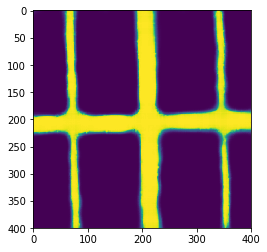

In [24]:
out = model(input_img)
mask = F.sigmoid(out)
mask_array = mask.data[0].cpu().numpy()[0]
mask_array = crop_image(mask_array, pads)
plt.imshow(mask_array)
plt.grid('off')